# Week 12: Telescope Image Reduction
This week we will be reducing images of Uranus and Neptune taken by the Keck telescope on Mauna Kea, Hawaii. 
## Import relevant packages
Note: this will not work if you are not running this notebook on your local computer with astroscrappy installed

In [1]:
#conda install -c astropy astroscrappy

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import medfilt
from scipy.interpolate import RectBivariateSpline
import astroscrappy

## How do ground based telescopes work?
Ground based telescopes are telescopes on Earth's surface (rather than space based telescopes, such as the Hubble Space Telescope which orbits Earth). The primary difference between ground based and space based telescopes is the wavelengths they can observe, due to absorption by Earth's atmosphere:

<img src="./data/atmosphere.jpg" width = 700>
Image Credit: Rice University

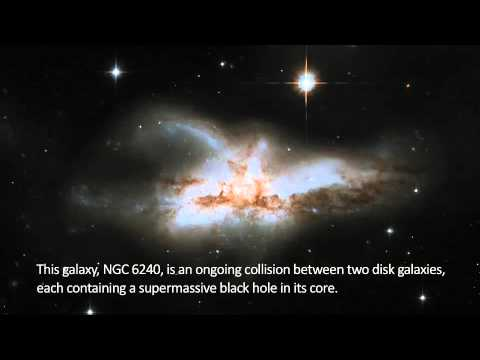

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('EzpGxyuKo_M', width=800, height=500)

Today we will be reducing images of Uranus taken by Keck Observatory's NIRC2 (near-infrared) instrument in 2 filters - Kp (1.948-2.299µm) and H (1.485-1.781µm). Images taken by ground-based telescopes must be calibrated for atmospheric effects, detector artifacts, and cosmic rays in order to be used for science.

Let's start by defining the filepath and variable names.

In [4]:
filt_name = 'h'
target_name = 'Uranus'
filepath = './data/'

skyf = filepath + 'sky_' + filt_name + '.fits'
uranusf = filepath + target_name + '_' + filt_name + '.fits'
flatf = filepath + 'flat_master_' + filt_name + '.fits'

print('Uranus image filepath = ' + uranusf)
print('Sky image filepath = ' + skyf)
print('Flatfield image filepath = ' + flatf)

Uranus image filepath = ./data/Uranus_h.fits
Sky image filepath = ./data/sky_h.fits
Flatfield image filepath = ./data/flat_master_h.fits


# All the images which go into one final, reduced image:
1. **Target image** (uranusf) : image taken with target in the center of the field of view (in this case, our target is Uranus)


2. **Sky image** (skyf) : image taken of open sky (without target or other bright objects) to account for *atmospheric* artifacts


3. **Flat-field image** (flatf) : image taken with a known light source before opening the telescope dome, to account for *detector* artifacts

## What is a fits file?
Fits files are the most commonly used data file format for astronomical observations. They have two components: a **header** which holds all the useful information about the observation, and the **data** which is the image itself.

Let's open the Uranus fits file and see what's inside.

In [5]:
uranus = fits.open(uranusf,ignore_warnings=True,ignore_missing_end=True)

  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  t  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  }  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  }  ?  z [astropy.io.fits.card]
  |  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  |  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  v  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  |  ?  z  z  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  w  ?  o  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  {  ?  ?  ?  ?  ?  ?  ?  }  ?  ~  ?  ?  ?  w [astropy.io.fits.card]
  {    f  ?  ?  ?  ?  ?  ?  ?  ?    |  h  ?  y  ?  f  ?  r [astropy.io.fits.card]
  ?  ?  ?    o  ?  ?  ?  u  j  x  }  ?  z  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?    ~  i  Q  `

All fits files have a header, which contains information about the data within the fits file, including the date and time of observation, instrument, filter, and many other technical details that may be useful in analysis of the image.

In [6]:
uranus[0].header

SIMPLE  =                    T / Tape is in Fits format                         
BITPIX  =                   32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 1024 / Number of pixels in axis 1                     
NAXIS2  =                 1024 / Number of pixels in axis 2                     
EXTEND  =                    T                                                  
BSCALE  =              1.00000 / Scaling factor                                 
BZERO   =              0.00000 / Scaling zero-point                             
OUTDIR  = '/sdata901/nirc6/2020sep08/            ' / Original directory         
ROOTNAME= 'n                 ' / File prefix                                    
FRAMENO =                  321 / Frame number                                   
FILENAME= 'n0321.fits        ' / Original File name                             
TELESCOP= 'Keck II          

Extract image data from fits file using .data and store in a variable called **uranus_data**.

In [7]:
uranus_data = uranus[0].data
uranus_data.shape

(1024, 1024)

We will also extract image data from the sky fits file and store that in the variable called **sky_data**.

In [8]:
sky = fits.open(skyf,ignore_missing_end=True,ignore_warnings=True)
sky_data = sky[0].data

  [  ]  [  [  f  O  j  d  p  K  N  ^  c  _  c  V  o  Z  d  e [astropy.io.fits.card]
  `  Y  ^  M  C  =  T  L  ^  T  I  P  t  V  `  `  b  d  e  j [astropy.io.fits.card]
  d  ?  [  A  E  M  W  L  I  K  _  f  ^  Q  T  Z  [  ^  _  _ [astropy.io.fits.card]
  M  Y  c  P  f  [  b  {  i  _    o  ?  g  s  l  d  U  ?  ] [astropy.io.fits.card]
  g  k  f  y  g  T  f  d  g  ^  ]  P  n  ~  Z  i  T  <  O  L [astropy.io.fits.card]
  [  >  3  K  ,  C  e  D  N  V  b  <  b  4  @  <  ;  O  F  N [astropy.io.fits.card]
  u  [  `  X  k  _  \  \  R  O  L  L  A  V  K  Q  T  W  ]  X [astropy.io.fits.card]
  J  K  O  P  M  H  K  E  I  E  J  C  ?  ;  L  P  U  ^  P  T [astropy.io.fits.card]
  D  ?  _  Q  F  5  H  @  ]  5  G  =  G  H  T  <  K  ?  9  D [astropy.io.fits.card]
  L  C  ;  I  U  >  4  T  J  L  L  .  J  =  c  R

# Part 1. Sky Subtraction
Let's plot up the Uranus and sky images to see what they look like:

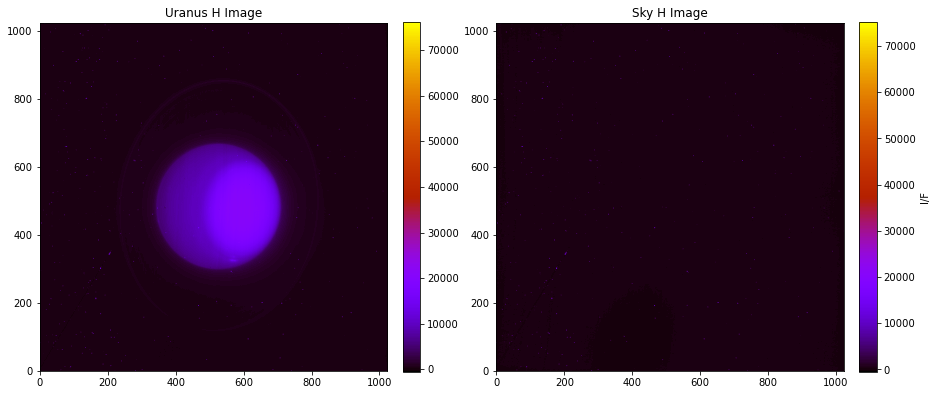

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_data,origin='lower',cmap='gnuplot')
plt.title('Uranus H Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(sky_data,origin='lower',cmap='gnuplot')
plt.title('Sky H Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Notice those few extremely bright pixels in both images? NIRC2 observes in the *thermal infrared* (1-5 micron) range, meaning it is essentially recording *heat*. Earth's atmosphere is way warmer than Uranus! In order to account for thermal radiation from Earth's atmosphere, we take one image of our target (Uranus), and one image off-target (open sky) and simply subtract the sky image from the target image. This is called **sky subtraction**, and it is a very commonly used technique in ground-based telescope image processing.

<font color=goldenrod>**_Code for you to write_**</font>

Let's write a function called ```subtract_sky()``` that takes the target image (*uranus_data*) and the sky image (*sky_data*) as inputs and returns an image where the sky image is subtracted from the target image:

In [11]:
def subtract_sky(image,sky):
    skysub = image - sky
    return skysub

In [12]:
uranus_skysub = subtract_sky(uranus_data,sky_data)

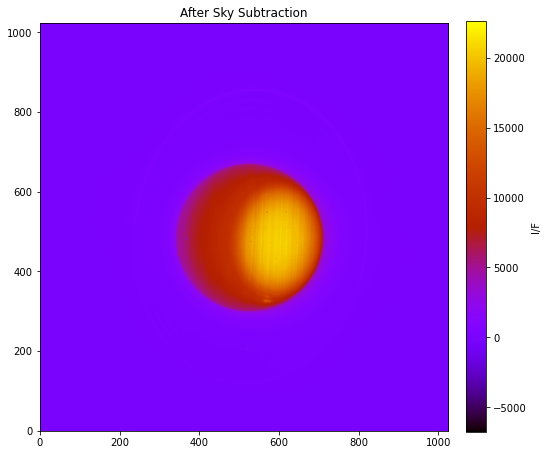

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_skysub,origin='lower',cmap='gnuplot')
plt.title('After Sky Subtraction')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Now Uranus is the brightest feature in our image!

But what is that grid pattern that's showing up on the brightest part of the planet? Is that real or is that another artifact?

# Part 2. Flat-fielding
Let's take a look at the flat-field image:

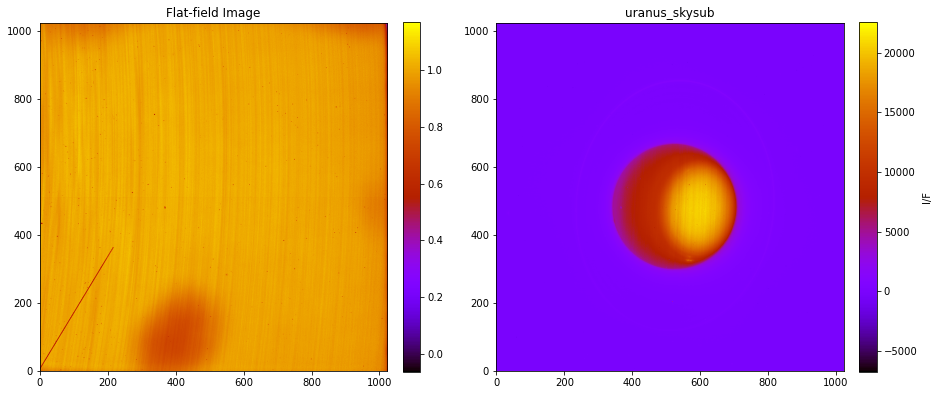

In [15]:
flat_fits = fits.open(flatf,ignore_warnings=True,ignore_missing_end=True)
flat = flat_fits[0].data

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(flat,origin='lower',cmap='gnuplot')
plt.title('Flat-field Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_skysub,origin='lower',cmap='gnuplot')
plt.title('uranus_skysub')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

A 'flat-field' is an image taken while the telescope dome is closed (no outside light) while a known, constant light source is shined on the detector. The light source has an intensity = 1, so in a perfect world the flat-field image would be an image where all pixels = 1. Clearly, this is not the case. 

In order to account for issues with the detector, we start by scaling all pixels by the flat image in order to account for discrepancies in the detector.

<font color=goldenrod>**_Code for you to write_**</font>

Let's write a function called ```apply_flat()``` that takes the target image (*uranus_skysub*) and the flat-field image (*flat*) as inputs and returns an image where the target image is divided by the flat-field image:

In [16]:
def apply_flat(image,flat):
    apply_flat = image / flat
    return apply_flat

In [17]:
uranus_apply_flat = apply_flat(uranus_skysub,flat)

<ipython-input-16-4e9ce96b593d>:2: RuntimeWarning: divide by zero encountered in true_divide
  apply_flat = image / flat


Text(0.5, 1.0, 'After Applying Flat Image')

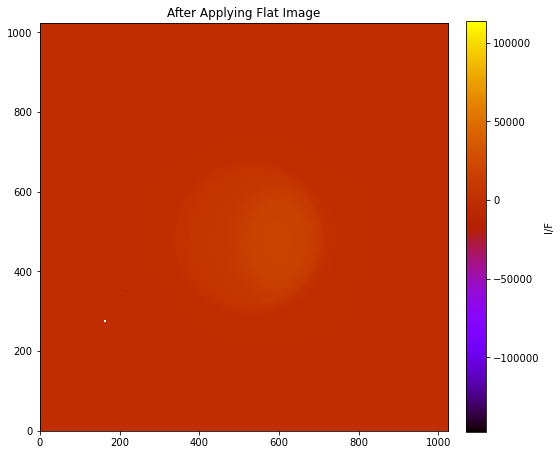

In [18]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_apply_flat,origin='lower',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Applying Flat Image')

The image looks worse, but don't panic! Since we are dividing by the flat image where good pixels = 1 and bad pixels ~ 0, bad pixels will be greatly exaggerated.

# Part 3. Removing bad pixels
We can identify and remove bad pixels by creating a "bad pixel map", which will note the location of all pixels whose value are exceptionally different from those of their neighbors.

In [19]:
def make_badpx_map(flat, outfile, tol, blocksize):
        badpx_map = np.ones(flat.shape)
        for i in range(0,flat.shape[0]+blocksize,blocksize):
            for j in range(0,flat.shape[1]+blocksize,blocksize):
                flatblock = flat[i:i+blocksize,j:j+blocksize]
                mapblock = badpx_map[i:i+blocksize,j:j+blocksize]
                med = np.median(flatblock)
                
                #if not within tolerance, set to NaN
                mapblock[np.where(flatblock/med > 1 + tol)] = 0
                mapblock[np.where(flatblock/med < 1 - tol)] = 0
                badpx_map[i:i+blocksize,j:j+blocksize] = mapblock
        fits.writeto(outfile,data=badpx_map, overwrite=True)

This function creates a "bad pixel map" based on the flat field image, where good pixels = 1 and bad pixels = 0. 

Let's create a bad pixel map for our flat image, which will be saved as 'badpx_h.fits'

In [20]:
make_badpx_map(flat=flat,outfile=filepath+'/badpx_'+filt_name+'.fits',tol = 0.045, blocksize = 7)

/Users/ddreger/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/ddreger/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


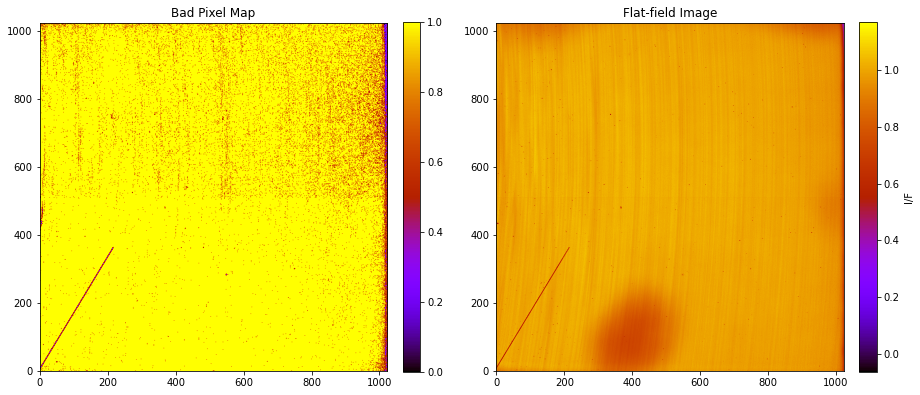

In [22]:
badpx_fits = fits.open(filepath+'badpx_' + filt_name + '.fits',ignore_missing_end=True)
badpx_map = badpx_fits[0].data

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(badpx_map,origin='lower',cmap='gnuplot')
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Bad Pixel Map')
plt.subplot(122)
plt.imshow(flat,origin='lower',cmap='gnuplot')
plt.title('Flat-field Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Lots of bad pixels! We can remove them from our image by using a nearest-neighbor smoothing technique.

In [23]:
def remove_bad_pixels(image,badpx_map):
    bad_indices = np.where(badpx_map == 0)
    smoothed = medfilt(image,kernel_size = 7)
    image[bad_indices] = smoothed[bad_indices]
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i,j] < 0.0:
                image[i,j] = 0.0
    return image

For all pixels in the image where badpx = 0, the image pixel value will be replaced by the median value of the pixels surrounding it.

In [24]:
uranus_rm_bp = remove_bad_pixels(uranus_apply_flat,badpx_map)

Text(0.5, 1.0, 'After Removing Bad Pixels')

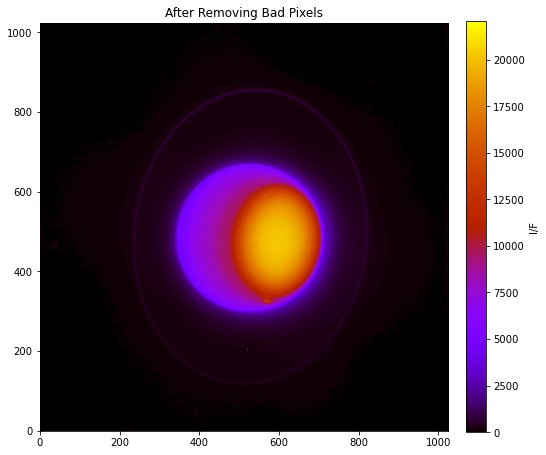

In [25]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_rm_bp,origin='lower',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('After Removing Bad Pixels')

OK, we're getting somewhere! One final step...

# Part 4. Cosmic Ray Removal
Those few remaining extremely bright pixels are actually real - they are cosmic rays. Cosmic rays are extremely high-energy protons originating from activity on our sun, supernovae explosions, and other high-energy intergalactic events.

We'll use a Python package called *astroscrappy*, which identifies and removes cosmic rays quite nicely.

In [26]:
def remove_cosmics(image):
    crmask, cleanarr = astroscrappy.detect_cosmics(image, cleantype='medmask')
    image = cleanarr
    return image

In [27]:
uranus_h = remove_cosmics(uranus_rm_bp)

Text(0.5, 1.0, 'Uranus H-Band Final Image')

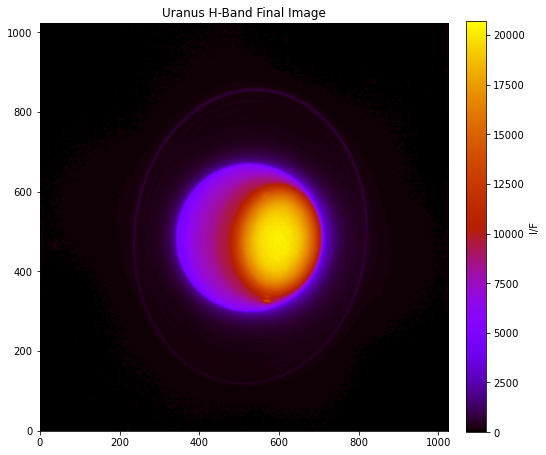

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(uranus_h,origin='lower',cmap='gnuplot')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')
plt.title('Uranus H-Band Final Image')

:O Amazing! Let's save this image as a fits file.

In [29]:
fits.writeto(filepath+'/uranus_'+filt_name+'_final.fits',data=uranus_h, overwrite=True)

# Reduce second Uranus image with a different filter

Great! We reduced an image. Let's reduce another image of Uranus, this time with a different filter (Kp).

Load the target, sky, and flat-field image for Kp filter...

In [30]:
filt_name = 'kp'
target_name = 'Uranus'
filepath = './data/'

skyf = filepath + 'sky_' + filt_name + '.fits'
uranusf = filepath + target_name + '_' + filt_name + '.fits'
flatf = filepath + 'flat_master_' + filt_name + '.fits'

print('Uranus image filepath = ' + uranusf)
print('Sky image filepath = ' + skyf)
print('Flatfield image filepath = ' + flatf)

Uranus image filepath = ./data/Uranus_kp.fits
Sky image filepath = ./data/sky_kp.fits
Flatfield image filepath = ./data/flat_master_kp.fits


In [31]:
uranus = fits.open(uranusf,ignore_warnings=True,ignore_missing_end=True)
uranus_data = uranus[0].data
sky = fits.open(skyf,ignore_missing_end=True,ignore_warnings=True)
sky_data = sky[0].data
flat_fits = fits.open(flatf,ignore_warnings=True,ignore_missing_end=True)
flat = flat_fits[0].data

  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?    ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  u  ?  ?  ?  |  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  y  l  ^  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?    &     ?      ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?    ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  6  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  {  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ~  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  t  r  r  ?  ?  ?  ? [astropy.io.fits.card]
  ?  (  .    ?  ?    ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ? [astropy.io.fits.card]
  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?  ?

<font color=goldenrod>**_Code for you to write_**</font>

Since you have already written functions for each of the image reduction techniques, you can call those functions to quickly reduce the next filter.

In [32]:
uranus_skysub = subtract_sky(uranus_data,sky_data)
uranus_apply_flat = apply_flat(uranus_skysub,flat)

make_badpx_map(flat = flat ,outfile=filepath+'/badpx_'+filt_name+'.fits',tol = 0.045, blocksize = 4)
uranus_rm_bp = remove_bad_pixels(uranus_apply_flat,badpx_map)
uranus_kp = remove_cosmics(uranus_rm_bp)

<ipython-input-16-4e9ce96b593d>:2: RuntimeWarning: divide by zero encountered in true_divide
  apply_flat = image / flat


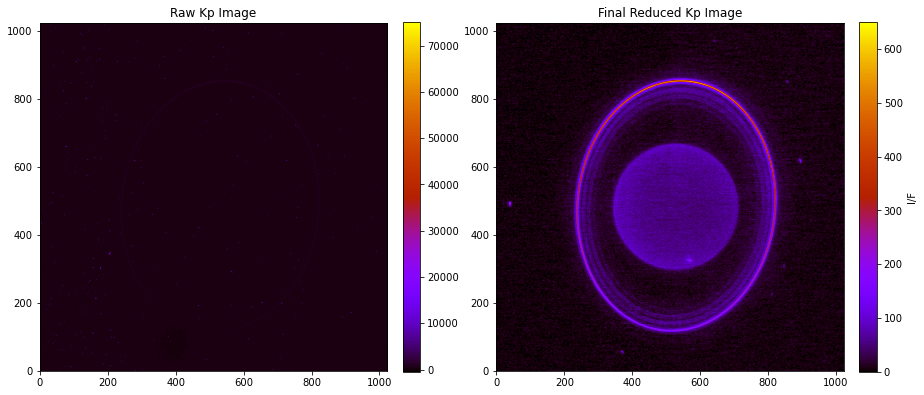

In [33]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_data,origin='lower',cmap='gnuplot')
plt.title('Raw Kp Image')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_kp,origin='lower',cmap='gnuplot')
plt.title('Final Reduced Kp Image')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

Plot the final, reduced images side by side to see how they look.

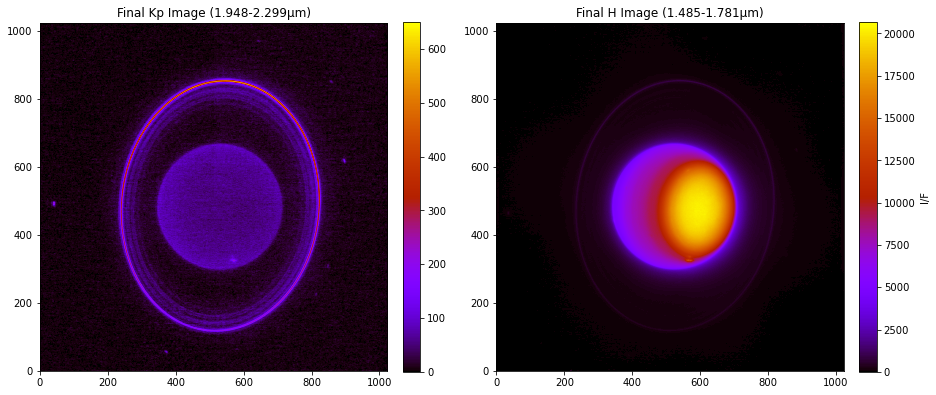

In [36]:
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_kp,origin='lower',cmap='gnuplot')
plt.title('Final Kp Image (1.948-2.299µm)')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_h,origin='lower',cmap='gnuplot')
plt.title('Final H Image (1.485-1.781µm)')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

# Simple cloud pressure analysis
We can use the ratio of the intensity of the Kp/H images to find the pressure of clouds in the atmosphere. Let's look at the one bright cloud that is visible in both images.

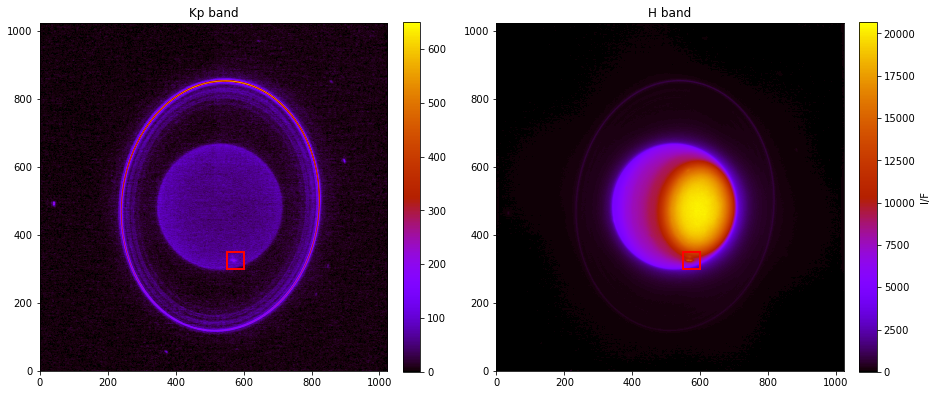

In [38]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15,10))
plt.subplot(121)
plt.imshow(uranus_kp,origin='lower',cmap='gnuplot')
ax = plt.gca()
rect = mpatches.Rectangle(xy=(550,300),width=50,height=50,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.title('Kp band')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(122)
plt.imshow(uranus_h,origin='lower',cmap='gnuplot')
ax = plt.gca()
rect2 = mpatches.Rectangle(xy=(550,300),width=50,height=50,linewidth=2,edgecolor='r',facecolor='none')
ax.add_patch(rect2)
plt.title('H band')
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label('I/F')

We can find the pressure of the cloud using the measured Kp/H ratio. This can be calculated by dividing the intensity of the cloud in Kp minus the background noise of the Kp image over the intensity of the cloud in H minus the background noise of the H image:

kp_h_ratio = (cloud_kp - background_kp)/(cloud_h - background_h)

To calculate this ratio, we need to determine the intensity of the cloud in both images, as well as the background noise in each image. Let's start by looking at the cloud in both images:

Text(0.5, 1.0, 'Zoomed-in cloud (H)')

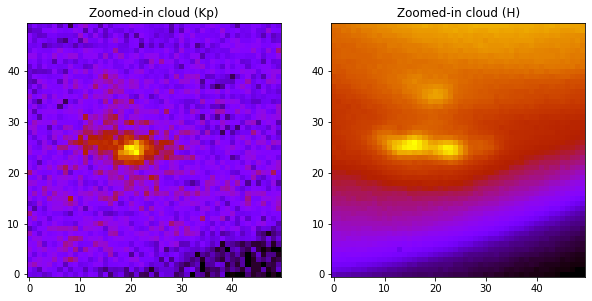

In [40]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(uranus_kp[300:350,550:600],origin='lower',cmap='gnuplot')
plt.title('Zoomed-in cloud (Kp)')
plt.subplot(122)
plt.imshow(uranus_h[300:350,550:600],origin='lower',cmap='gnuplot')
plt.title('Zoomed-in cloud (H)')

<font color=goldenrod>**_Code for you to write_**</font>

Let's assume that the cloud is represented by the *maximum* value in the cloud area in each image, and the background noise is the *median* value of an area in the background sky. Write some code to define variables ```cloud_kp``` and ```cloud_h``` as the maximum pixel value in our selected cloud area, and ```background_kp``` and ```background_h``` as the median pixel values in our selected background area.

In [41]:
cloud_kp = np.max(uranus_kp[300:350,550:600])
cloud_h = np.max(uranus_h[300:350,550:600])
print(cloud_kp,cloud_h)

291.6228 14863.762


Now let's find a good section of the background sky to use as a measurement of the background noise.

Text(0.5, 1.0, 'Background sky noise (H)')

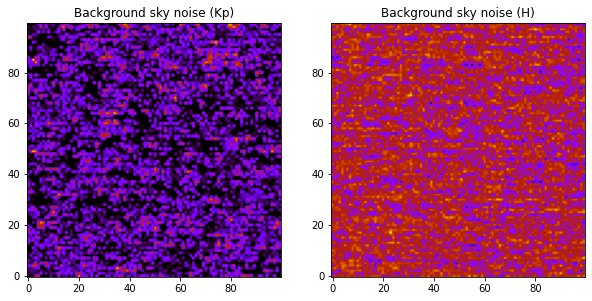

In [43]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(uranus_kp[900:1000,900:1000],origin='lower',cmap='gnuplot')
plt.title('Background sky noise (Kp)')
plt.subplot(122)
plt.imshow(uranus_h[900:1000,900:1000],origin='lower',cmap='gnuplot')
plt.title('Background sky noise (H)')

In [44]:
background_kp = np.median(uranus_kp[900:1000,900:1000])
background_h = np.median(uranus_h[900:1000,900:1000])
print(background_kp,background_h)

4.011738 62.131252


Calculate *kp_h_ratio* using the equation above.

In [45]:
kp_h_ratio = (cloud_kp-background_kp)/(cloud_h-background_h)
kp_h_ratio

0.019431038

Use the following graph to estimate pressure of the bright cloud, given your calculated Kp/H ratio. Pressure is in bars.

<img src="data/pressure_graph.png" width = 500 align = 'left'>